In [1]:
import pandas as pd
from pandas_datareader import wb
import io

# =============================================================================
# ADIM 1: TEMEL VERİ SETİNİN OLUŞTURULMASI (Ülkeler, Kıtalar ve Siyasi Yönelim)
# =============================================================================
csv_skeleton = """Country,Continent,Political_Orientation,incomeLevel
Afghanistan,Asia,Right,LIC
Albania,Europe,Left,UMC
Algeria,Africa,Center,UMC
Argentina,South America,Left,UMC
Australia,Oceania,Left,HIC
Austria,Europe,Right,HIC
Azerbaijan,Asia,Right,UMC
Belgium,Europe,Center,HIC
Bolivia,South America,Left,LMC
Bosnia and Herzegovina,Europe,Right,UMC
Brazil,South America,Right,UMC
Bulgaria,Europe,Center,HIC
Canada,North America,Left,HIC
Chile,South America,Left,HIC
China,Asia,Left,UMC
Colombia,South America,Left,UMC
Costa Rica,North America,Right,HIC
Croatia,Europe,Right,HIC
Cyprus,Europe,Right,HIC
Czechia,Europe,Right,HIC
Denmark,Europe,Left,HIC
Ecuador,South America,Right,UMC
Egypt,Africa,Right,LMC
Estonia,Europe,Right,HIC
Finland,Europe,Left,HIC
France,Europe,Center,HIC
Georgia,Asia,Center,UMC
Germany,Europe,Left,HIC
Ghana,Africa,Right,LMC
Greece,Europe,Right,HIC
Hungary,Europe,Right,HIC
Iceland,Europe,Left,HIC
India,Asia,Right,LMC
Indonesia,Asia,Center,UMC
Iran,Asia,Right,UMC
Iraq,Asia,Right,UMC
Ireland,Europe,Right,HIC
Israel,Asia,Right,HIC
Italy,Europe,Right,HIC
Japan,Asia,Right,HIC
Kazakhstan,Asia,Center,UMC
Kenya,Africa,Right,LMC
"Korea, Rep.",Asia,Right,HIC
Latvia,Europe,Right,HIC
Lithuania,Europe,Right,HIC
Malaysia,Asia,Center,UMC
Mexico,North America,Left,UMC
Moldova,Europe,Right,UMC
Mongolia,Asia,Left,UMC
Morocco,Africa,Right,LMC
Netherlands,Europe,Right,HIC
New Zealand,Oceania,Left,HIC
Nigeria,Africa,Left,LMC
North Macedonia,Europe,Left,UMC
Norway,Europe,Left,HIC
Pakistan,Asia,Right,LMC
Peru,South America,Left,UMC
Philippines,Asia,Right,LMC
Poland,Europe,Right,HIC
Portugal,Europe,Left,HIC
Qatar,Asia,Right,HIC
Romania,Europe,Right,HIC
Russian Federation,Europe,Right,HIC
Saudi Arabia,Asia,Right,HIC
Serbia,Europe,Right,UMC
Singapore,Asia,Right,HIC
Slovak Republic,Europe,Right,HIC
Slovenia,Europe,Center,HIC
South Africa,Africa,Left,UMC
Spain,Europe,Left,HIC
Sri Lanka,Asia,Right,LMC
Sweden,Europe,Right,HIC
Switzerland,Europe,Right,HIC
Thailand,Asia,Right,UMC
Tunisia,Africa,Center,LMC
Turkiye,Europe,Right,UMC
Ukraine,Europe,Center,UMC
United Arab Emirates,Asia,Right,HIC
United Kingdom,Europe,Right,HIC
United States,North America,Left,HIC
Uruguay,South America,Right,HIC
Uzbekistan,Asia,Center,LMC
"Venezuela, RB",South America,Left,INX
Vietnam,Asia,Left,LMC
"""

# Metni DataFrame'e çeviriyoruz
df_base = pd.read_csv(io.StringIO(csv_skeleton))

# =============================================================================
# ADIM 2: DÜNYA BANKASI API'SINDAN VERİ ÇEKME
# =============================================================================
print("Veriler Dünya Bankası'ndan çekiliyor, lütfen bekleyin...")

# WDI (World Development Indicators) Kodları
indicators = {
    'NY.GDP.PCAP.CD': 'GDP per capita (current US$)',
    'SE.SEC.ENRR.FE': 'School enrollment secondary female (% gross)',
    'SE.SEC.ENRR.MA': 'School enrollment secondary male (% gross)',
    'SI.POV.GINI': 'Gini Index',
    'SP.DYN.LE00.IN': 'Life Expectancy',
    'IT.NET.USER.ZS': 'Internet Usage %',
    'SL.TLF.CACT.FE.ZS': 'Female Labor Force %'
}

# API İsteği (Veriler gelmezse start=2021 deneyebilirsin)
wb_data = wb.download(indicator=list(indicators.keys()), country='all', start=2022, end=2023)
wb_data = wb_data.reset_index()

# Sütun İsimlerini Düzeltme
wb_data = wb_data.rename(columns=indicators)

# Gruplama ve En Güncel Veriyi Alma
target_cols = list(indicators.values())
wb_data_grouped = wb_data.groupby('country')[target_cols].first().reset_index()
wb_data_grouped = wb_data_grouped.rename(columns={'country': 'Country'})

# =============================================================================
# ADIM 3: VERİ TEMİZLEME VE BİRLEŞTİRME
# =============================================================================

corrections = {
    'Turkey': 'Turkiye',
    'Slovak Republic': 'Slovak Republic',
    'Egypt, Arab Rep.': 'Egypt',
    'Iran, Islamic Rep.': 'Iran',
    'Korea, Rep.': 'Korea, Rep.',
    'Russia': 'Russian Federation',
    'Venezuela, RB': 'Venezuela, RB',
    'Viet Nam': 'Vietnam',
    'Yemen, Rep.': 'Yemen'
}
wb_data_grouped['Country'] = wb_data_grouped['Country'].replace(corrections)

# Birleştirme
df_final = pd.merge(df_base, wb_data_grouped, on='Country', how='left')

# =============================================================================
# ADIM 4: KAYDETME
# =============================================================================

cols = [
    'Country', 'incomeLevel', 
    'GDP per capita (current US$)', 
    'School enrollment secondary female (% gross)',
    'School enrollment secondary male (% gross)',
    'Continent', 
    'Gini Index', 
    'Life Expectancy', 
    'Internet Usage %', 
    'Female Labor Force %', 
    'Political_Orientation'
]

# Mevcut sütunları seçip kaydet
existing_cols = [c for c in cols if c in df_final.columns]
df_final = df_final[existing_cols]

df_final.to_csv('DSA_Project_Data.csv', index=False)
    
print("\n--- İŞLEM BAŞARILI ---")
print("Dosya 'DSA_Project_Data.csv' adıyla kaydedildi.")
print(df_final.head())

Veriler Dünya Bankası'ndan çekiliyor, lütfen bekleyin...

--- İŞLEM BAŞARILI ---
Dosya 'DSA_Project_Data.csv' adıyla kaydedildi.
       Country incomeLevel  GDP per capita (current US$)  \
0  Afghanistan         LIC                    413.757895   
1      Albania         UMC                   8575.171346   
2      Algeria         UMC                   5364.027950   
3    Argentina         UMC                  14187.482725   
4    Australia         HIC                  64835.919975   

   School enrollment secondary female (% gross)  \
0                                           NaN   
1                                     92.668293   
2                                    103.220718   
3                                    107.980731   
4                                    131.097336   

   School enrollment secondary male (% gross)      Continent  Gini Index  \
0                                         NaN           Asia         NaN   
1                                   99.499010      

In [2]:
import pandas as pd

# 1. HAM VERİYİ YÜKLE
try:
    df = pd.read_csv('DSA_Project_Data.csv')
    print(f"Orijinal Veri Sayısı: {len(df)} satır")
except FileNotFoundError:
    print("Hata: 'DSA_Project_Data.csv' bulunamadı.")
    exit()

# 2. TEMİZLİK İŞLEMİ (Sadece Eksik Verileri Atıyoruz)
# Verisi eksik olan ülkeleri siliyoruz çünkü model bunlarla çalışamaz.
df_clean = df.dropna().reset_index(drop=True)

# 3. KONTROL
print(f"Temizlenmiş Veri Sayısı: {len(df_clean)} satır")
print(f"Silinen Ülke Sayısı: {len(df) - len(df_clean)}")

# Hangi ülkeler kaldı bir görelim
print("\nVeri Setindeki İlk 5 Ülke:")
print(df_clean[['Country', 'Continent', 'Political_Orientation']].head())

# 4. KAYDETME
# Bu dosya EDA yapmak (grafik çizmek) için kullanacağın ana dosyadır.
df_clean.to_csv('DSA_Project_Data_clean.csv', index=False)

print("\n--- İŞLEM TAMAM ---")
print("Dosya 'DSA_Project_Data_clean.csv' olarak kaydedildi.")

Orijinal Veri Sayısı: 84 satır
Temizlenmiş Veri Sayısı: 49 satır
Silinen Ülke Sayısı: 35

Veri Setindeki İlk 5 Ülke:
     Country      Continent Political_Orientation
0  Argentina  South America                  Left
1    Austria         Europe                 Right
2    Belgium         Europe                Center
3    Bolivia  South America                  Left
4     Brazil  South America                 Right

--- İŞLEM TAMAM ---
Dosya 'DSA_Project_Data_clean.csv' olarak kaydedildi.


--- İSTATİSTİKSEL ÖZET ---
                                              count          mean  \
GDP per capita (current US$)                   49.0  27033.009664   
School enrollment secondary female (% gross)   49.0    105.318662   
School enrollment secondary male (% gross)     49.0    102.755060   
Gini Index                                     49.0     34.824490   
Life Expectancy                                49.0     77.230289   
Internet Usage %                               49.0     84.580341   
Female Labor Force %                           49.0     54.606020   

                                                       std          min  \
GDP per capita (current US$)                  26028.657348  1596.636961   
School enrollment secondary female (% gross)     18.332396    47.406151   
School enrollment secondary male (% gross)       15.215019    46.398590   
Gini Index                                        6.927828    23.800000   
Life Expectancy                              

C:\Users\Ozan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Ozan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


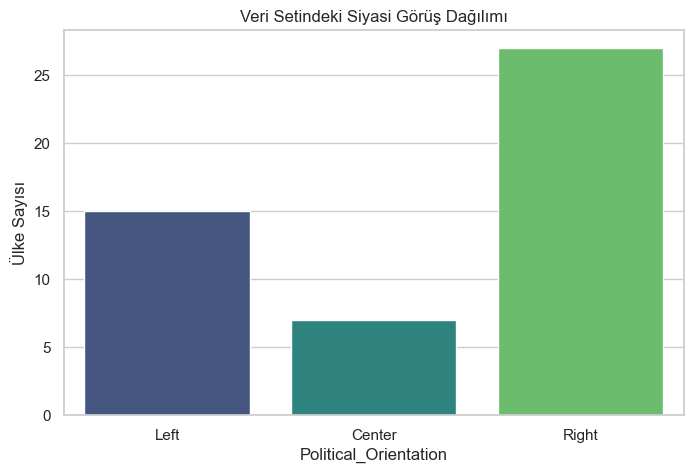


Yorum: Bu grafik, veri setinin dengeli olup olmadığını gösterir. Eğer bir sütun çok kısaysa model o sınıfı öğrenmekte zorlanabilir.


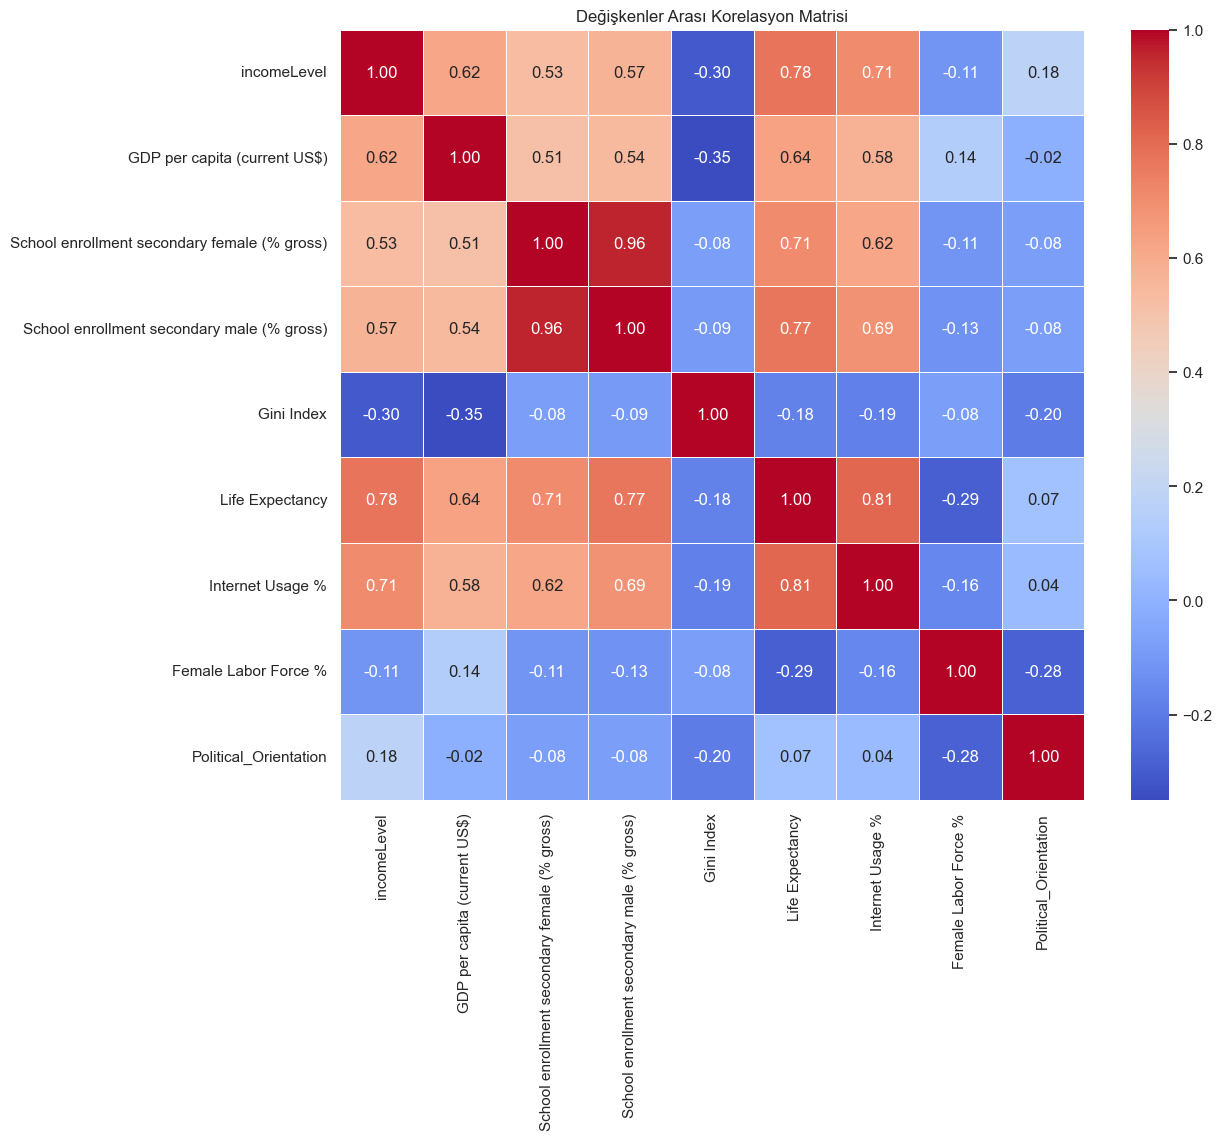


Yorum: Kırmızı kareler pozitif ilişkiyi (biri artarsa diğeri de artar), mavi kareler negatif ilişkiyi gösterir.


C:\Users\Ozan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Ozan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


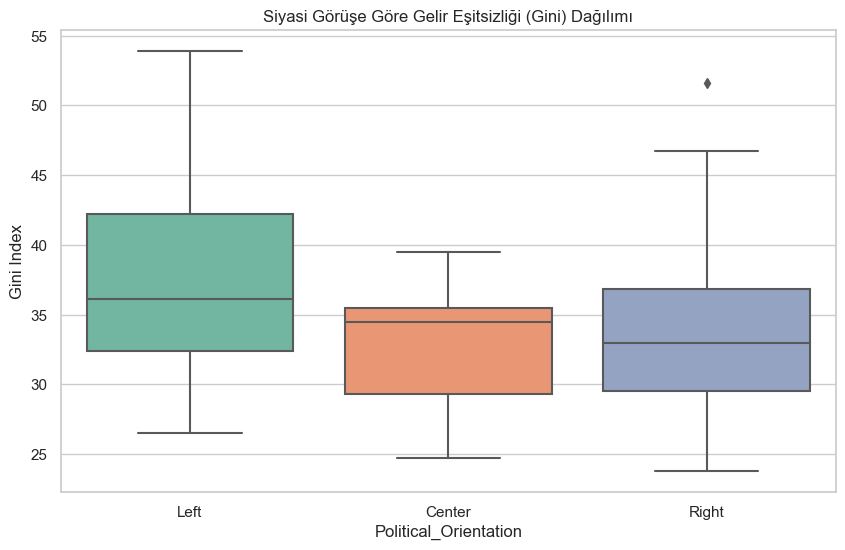

C:\Users\Ozan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Ozan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Ozan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) ins

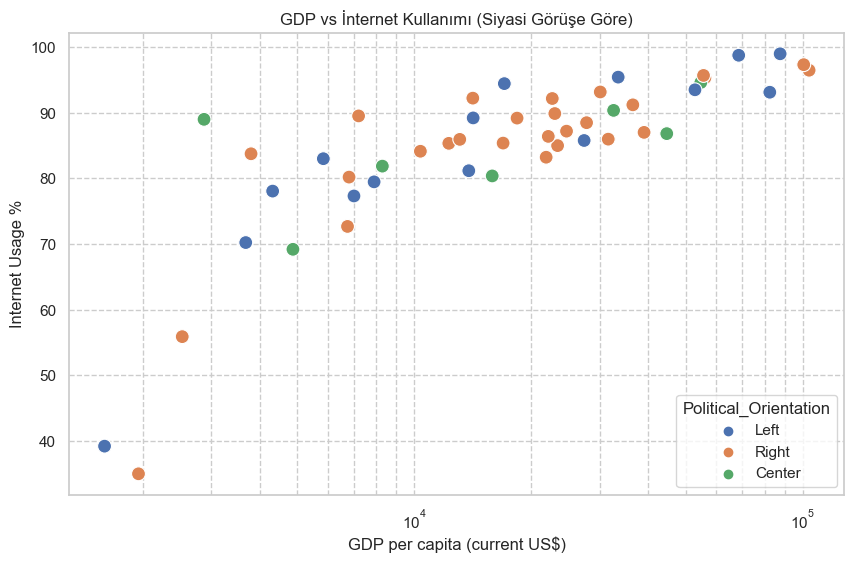


--- EDA TAMAMLANDI ---


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Görsel ayarları (Daha şık grafikler için)
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# 1. TEMİZ VERİYİ YÜKLE
try:
    df = pd.read_csv('DSA_Project_Data_clean.csv')
except FileNotFoundError:
    print("Dosya bulunamadı! Lütfen önce temizleme kodunu çalıştır.")
    exit()

# --- ADIM 1: VERİYE GENEL BAKIŞ (Sayısal Özet) ---
print("--- İSTATİSTİKSEL ÖZET ---")
# describe() komutu ortalama, min, max değerlerini döker.
print(df.describe().T) 

# --- ADIM 2: HEDEF DEĞİŞKEN DAĞILIMI (Siyasi Görüş) ---
plt.figure(figsize=(8, 5))
sns.countplot(x='Political_Orientation', data=df, palette='viridis', order=['Left', 'Center', 'Right'])
plt.title("Veri Setindeki Siyasi Görüş Dağılımı")
plt.ylabel("Ülke Sayısı")
plt.show()
print("\nYorum: Bu grafik, veri setinin dengeli olup olmadığını gösterir. Eğer bir sütun çok kısaysa model o sınıfı öğrenmekte zorlanabilir.")

# --- ADIM 3: KORELASYON HARİTASI (HEATMAP) ---
# Not: Heatmap sayı istediği için geçici bir kopya üzerinde dönüşüm yapıyoruz.
df_corr = df.copy()
politics_map = {'Left': 0, 'Center': 1, 'Right': 2}
income_map = {'LIC': 1, 'LMC': 2, 'UMC': 3, 'HIC': 4, 'INX': 0}
df_corr['Political_Orientation'] = df_corr['Political_Orientation'].map(politics_map)
df_corr['incomeLevel'] = df_corr['incomeLevel'].map(income_map)
# Sadece sayısal sütunları seçip korelasyona bakıyoruz
numeric_cols = df_corr.select_dtypes(include=['number'])

plt.figure(figsize=(12, 10))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Değişkenler Arası Korelasyon Matrisi")
plt.show()
print("\nYorum: Kırmızı kareler pozitif ilişkiyi (biri artarsa diğeri de artar), mavi kareler negatif ilişkiyi gösterir.")

# --- ADIM 4: DETAYLI İLİŞKİ ANALİZLERİ (Boxplot & Scatter) ---

# Analiz A: Siyasi Görüş ve Gelir Adaletsizliği (Gini Index)
# "Sağcı ülkelerde mi yoksa Solcu ülkelerde mi gelir eşitsizliği daha fazla?"
plt.figure(figsize=(10, 6))
sns.boxplot(x='Political_Orientation', y='Gini Index', data=df, palette='Set2', order=['Left', 'Center', 'Right'])
plt.title("Siyasi Görüşe Göre Gelir Eşitsizliği (Gini) Dağılımı")
plt.show()

# Analiz B: Zenginlik ve İnternet Kullanımı İlişkisi (Siyasi Renklendirme ile)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='GDP per capita (current US$)', y='Internet Usage %', hue='Political_Orientation', data=df, palette='deep', s=100)
plt.title("GDP vs İnternet Kullanımı (Siyasi Görüşe Göre)")
plt.xscale('log') # GDP çok değişken olduğu için logaritmik ölçek kullanıyoruz
plt.grid(True, which="both", ls="--")
plt.show()

print("\n--- EDA TAMAMLANDI ---")

In [ ]:
import pandas as pd
from scipy import stats

# Veri
df = pd.read_csv('DSA_Project_Data_clean.csv')


print("\n--- EK HİPOTEZ TESTLERİ (4, 5, 6) ---\n")

# =============================================================================
# TEST 4: "COĞRAFYA KADER MİDİR?" (ANOVA - Kıta ve GDP)
# H0: Bütün kıtaların gelir ortalamaları EŞİTTİR.
# H1: En az bir kıta diğerlerinden anlamlı derecede farklıdır.
# =============================================================================
print("TEST 4: Kıtalar Arası Gelir Farklılığı (ANOVA)")

# Her kıtanın GDP verilerini bir listede topluyoruz
continents = df['Continent'].unique()
gdp_groups = [df[df['Continent'] == c]['GDP per capita (current US$)'] for c in continents]

# Grupları teste sokuyoruz 
f_stat, p_value = stats.f_oneway(*gdp_groups)

print(f"F-İstatistiği: {f_stat:.4f}")
print(f"P-Değeri: {p_value:.4e}")

if p_value < 0.05:
    print("SONUÇ: H0 Reddedildi. Kıtalar arasında UÇURUM (anlamlı gelir farkı) var.")
else:
    print("SONUÇ: H0 Reddedilemedi. Kıtaların gelirleri benzer.")
print("-" * 50)


# =============================================================================
# TEST 5: "PARA SAĞLIK GETİRİR Mİ?" (Pearson Korelasyonu - GDP vs Yaşam Süresi)
# H0: Zenginlik ile uzun yaşam arasında ilişki YOKTUR.
# H1: İlişki VARDIR.
# =============================================================================
print("\nTEST 5: GDP ile Yaşam Beklentisi İlişkisi (Pearson)")

# Korelasyon hesabı
corr_coef, p_value_corr = stats.pearsonr(df['GDP per capita (current US$)'], df['Life Expectancy'])

print(f"Korelasyon Katsayısı (r): {corr_coef:.4f}")
print(f"P-Değeri: {p_value_corr:.4e}")

if p_value_corr < 0.05:
    if corr_coef > 0:
        print("SONUÇ: H0 Reddedildi. Zenginlik arttıkça yaşam süresi ANLAMLI şekilde artıyor.")
    else:
        print("SONUÇ: H0 Reddedildi. Ancak ters bir ilişki var (Beklenmedik durum).")
else:
    print("SONUÇ: H0 Reddedilemedi. Para ile sağlık arasında bağ kurulamadı.")
print("-" * 50)


# =============================================================================
# TEST 6: "SİYASET EĞİTİMİ ETKİLER Mİ?" (ANOVA - Politics vs Female Education)
# H0: Sağ, Sol ve Merkez ülkelerde kadın okullaşma oranı EŞİTTİR.
# H1: Farklılık gösterir.
# =============================================================================
print("\nTEST 6: Siyasi Görüşe Göre Kadın Eğitimi Farkı (ANOVA)")

edu_right = df[df['Political_Orientation'] == 'Right']['School enrollment secondary female (% gross)']
edu_left = df[df['Political_Orientation'] == 'Left']['School enrollment secondary female (% gross)']
edu_center = df[df['Political_Orientation'] == 'Center']['School enrollment secondary female (% gross)']

f_stat, p_value = stats.f_oneway(edu_right, edu_left, edu_center)

print(f"F-İstatistiği: {f_stat:.4f}")
print(f"P-Değeri: {p_value:.4f}")

if p_value < 0.05:
    print("SONUÇ: H0 Reddedildi. Bazı siyasi görüşlerde kadın eğitimi istatistiksel olarak daha farklı.")
else:
    print("SONUÇ: H0 Reddedilemedi. Siyasetin kadın eğitimi üzerinde doğrudan bir etkisi görülmedi.")
print("-" * 50)


--- EK HİPOTEZ TESTLERİ (4, 5, 6) ---

TEST 4: Kıtalar Arası Gelir Farklılığı (ANOVA)
F-İstatistiği: 5.7747
P-Değeri: 7.9684e-04
SONUÇ: H0 Reddedildi. Kıtalar arasında UÇURUM (anlamlı gelir farkı) var.
--------------------------------------------------

TEST 5: GDP ile Yaşam Beklentisi İlişkisi (Pearson)
Korelasyon Katsayısı (r): 0.6356
P-Değeri: 9.2724e-07
SONUÇ: H0 Reddedildi. Zenginlik arttıkça yaşam süresi ANLAMLI şekilde artıyor.
--------------------------------------------------

TEST 6: Siyasi Görüşe Göre Kadın Eğitimi Farkı (ANOVA)
F-İstatistiği: 0.1838
P-Değeri: 0.8327
SONUÇ: H0 Reddedilemedi. Siyasetin kadın eğitimi üzerinde doğrudan bir etkisi görülmedi.
--------------------------------------------------
